# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

#### Данные о клиентах банка:
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

#### Прочие признаки:
- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'].value_counts()

balance
0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: count, Length: 3802, dtype: int64

In [7]:
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))
df['balance'].value_counts()

balance
 0.0       774
 1.0        39
 3.0        34
 2.0        34
 4.0        29
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: count, Length: 3802, dtype: int64

In [8]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# Находим модальные значения для признаков "job" и "education"
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

# Заменяем пропущенные значения на модальные
df['job'].replace(['unknown'], mode_job, inplace=True)
df['education'].replace(['unknown'], mode_education, inplace=True)

# Выбираем клиентов с самой популярной работой и самым популярным уровнем образования
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# Рассчитываем средний баланс для клиентов с самой популярной работой и уровнем образования
mean_balance_popular_job_education = df[(df['job'] == popular_job) & (df['education'] == popular_education)]['balance'].mean()

# Округляем ответ до трёх знаков после точки-разделителя
mean_balance_popular_job_education_rounded = round(mean_balance_popular_job_education, 3)

mean_balance_popular_job_education_rounded

1598.883

### Задание 6

In [11]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
q1 = df.balance.quantile(0.25)  # 25-й перцентиль
q3 = df.balance.quantile(0.75)  # 75-й перцентиль
iqr = q3 - q1                         # межквартильный размах
lower_bound = q1 - (iqr*1.5)          # нижняя граница выбросов
upper_bound = q3 + (iqr*1.5)          # верхняя граница выбросов
display(lower_bound, upper_bound)

-2241.0

4063.0

In [12]:
df_cleaned = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)] 
df_cleaned.count()

age          10105
job          10105
marital      10105
education    10105
default      10105
balance      10105
housing      10105
loan         10105
contact      10105
day          10105
month        10105
duration     10105
campaign     10105
pdays        10105
previous     10105
poutcome     10105
deposit      10105
dtype: int64

## Часть 2:  Разведывательный анализ

### Задание 1

In [13]:
import plotly
import plotly.express as px
import plotly.io as pio

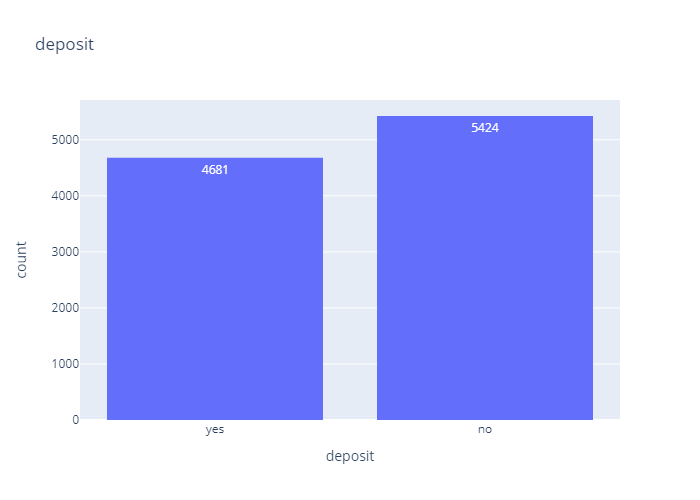

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = px.histogram(df_cleaned, x='deposit', title='deposit', text_auto=True)
fig.show('png')

### Задания 2 и 3

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

In [17]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

Визуализируем зависимости целевого признака(deposit - клиенты открывшие депозит) от количественных переменных. Сделаем промежуточные выводы.

**1. AGE(возраст)**

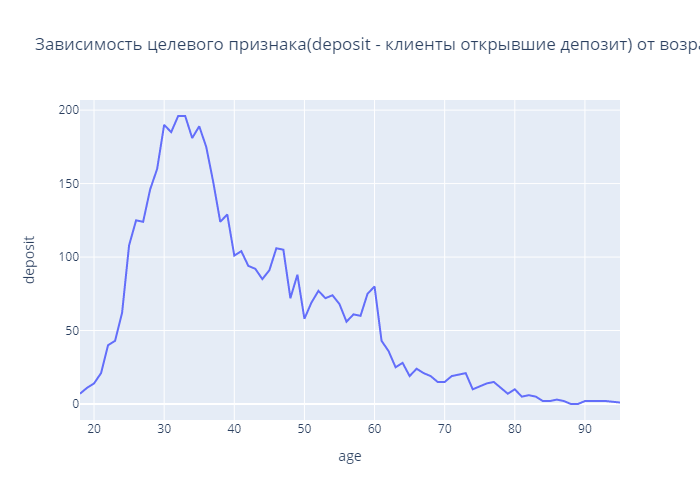

In [18]:
fig = px.line(pd.DataFrame(df_cleaned.groupby('age')['deposit'].sum()).reset_index(), x='age', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от возраста(age)')
fig.show('png')

Признак возраст имеет распределение в диапазоне от 18 до 95 лет. На графике видно, что начиная от 18 лет резко возрастает в абсолютном значении количество открываемых депозитов клиентами банка достигая пика при age=31-33 года, далее достигнув возраста 36 лет - только плавно падая.

**2. DAY(день, в который был последний контакт)**

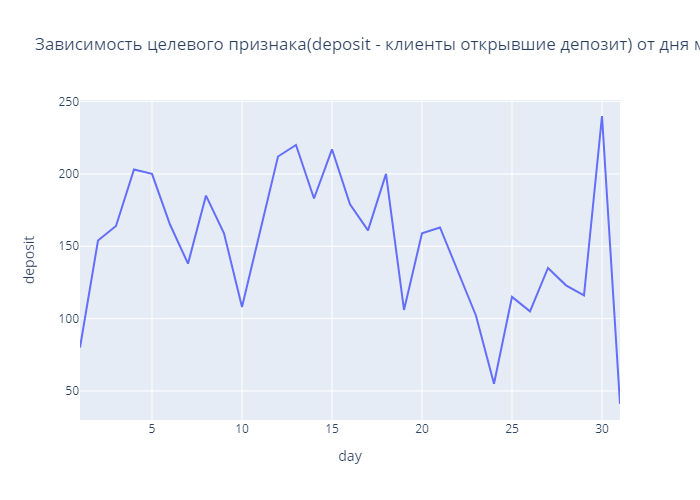

In [19]:
fig = px.line(pd.DataFrame(df_cleaned.groupby('day')['deposit'].sum()).reset_index(), x='day', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от дня месяца(day), в который был последний контакт')
fig.show('png')

Видим локальные пики в конце месяца(30 день), в середине месяца(с 12-18 дни), в начале месяца(4-5 дни), а также локальные минимумы: первое и последнее дни месяца, 10 день месяца, 19 и 24 дни.
Возможно это связано с получение в пиковые дни доходов клиентами(заработной платы, пенсионных/социальных выплат) и промежутков соответсвующие минимумам.

**3. DURATION(продолжительность контакта в секундах)**

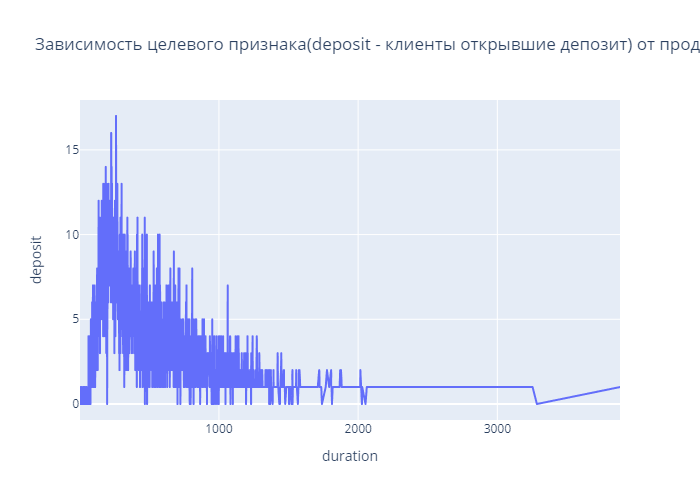

In [20]:
fig = px.line(pd.DataFrame(df_cleaned.groupby('duration')['deposit'].sum()).reset_index(), x='duration', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от продолжительность контакта в секундах(duration)')
fig.show('png')

Видим, что увеличение продолжительности контакта увеличивает целевую переменную приблизительно до 300 секунд, далее идёт падение. Можно заметить резанность графика - разброс количества открытых депозитов при определённой продолжительности - что говорит о неединственном факторе влияющем на целевой признак и/или влияющий на него слабо.

**4. CAMPAIGN(количество контактов с этим клиентом в течение текущей кампании)**

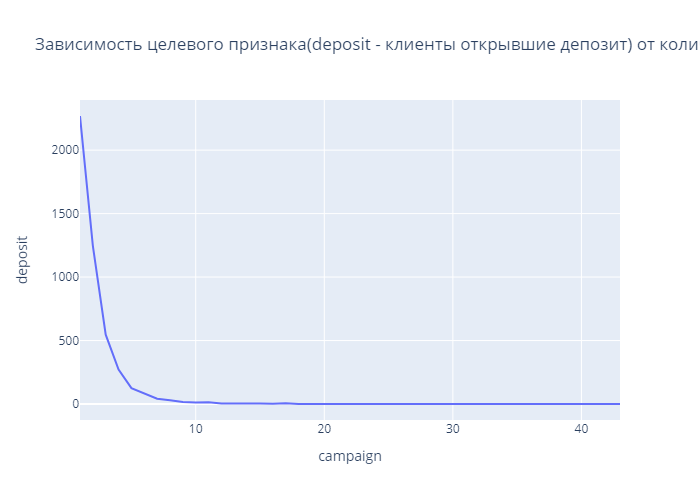

In [21]:
fig = px.line(pd.DataFrame(df_cleaned.groupby('campaign')['deposit'].sum()).reset_index(), x='campaign', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов с этим клиентом в течение текущей кампании(campaign)')
fig.show('png')

График зависимости показывает, что возможно необходимо ограничиться до 3-4 контактов с клиентом.

**5. PREVIOUS(количество контактов до текущей кампании)**

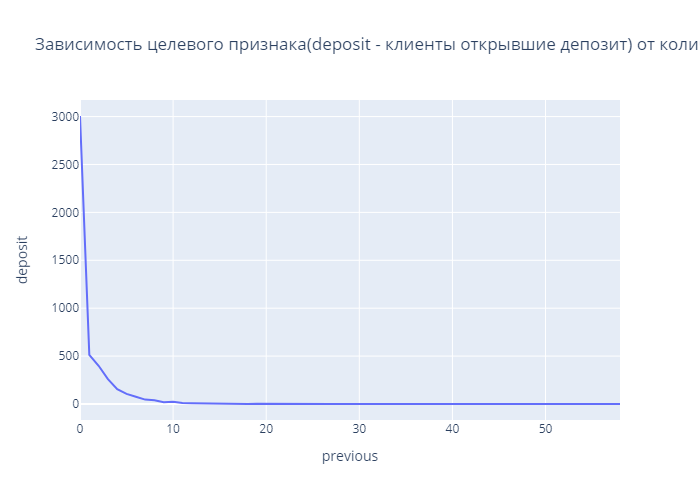

In [22]:
fig = px.line(pd.DataFrame(df_cleaned.groupby('previous')['deposit'].sum()).reset_index(), x='previous', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов до текущей кампании(previous)')
fig.show('png')

Чем меньше контактов было с клиентом до текущей кампании, тем ввыше шанс открытия депозита клиентом. При контактак более 5 шансы открытия депозита становятся нулевыми.

**6. JOB(сфера занятости)**

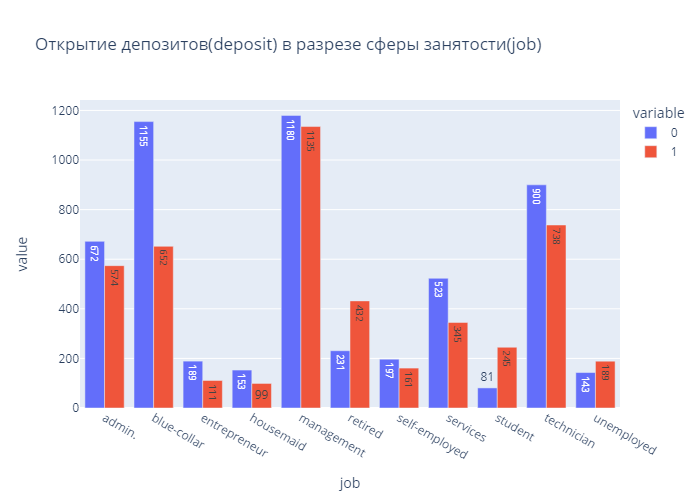

In [23]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='job', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе сферы занятости(job)')
fig.show('png')

Имеется тенденция к согласию открыть депозит у клиентов, находящихся на пенсии(retired), среди студентов(student), безработных(unemployed). Больше всего отказываются: клиенты, в рабочих специальностях(blue-collar), предприниматели(entrepreneur), занятые в сфере обслуживания(housemaid).

**7. MARITAL(семейное положение)**

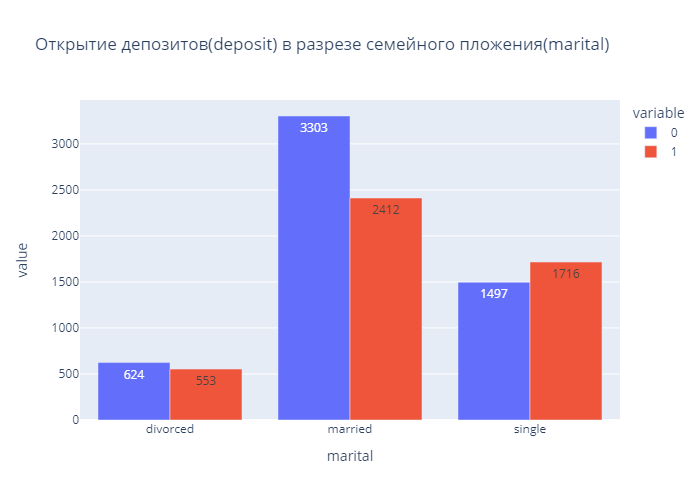

In [24]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='marital',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='marital', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе семейного пложения(marital)')
fig.show('png')

При семейном положении холост(single) есть тенденция открывать депозит, а не отказываться от его открытия.

**8. EDUCATION(уровень образования)**

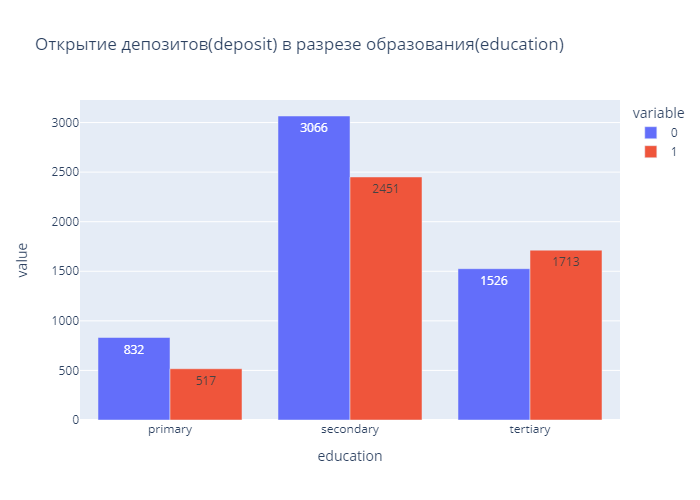

In [25]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='education', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе образования(education)')
fig.show('png')

Прослеживается положительная тенденция открытия депозита клиентов с уровнем образования tertiary.

**9. HOUSING(имеется ли кредит на жильё)**

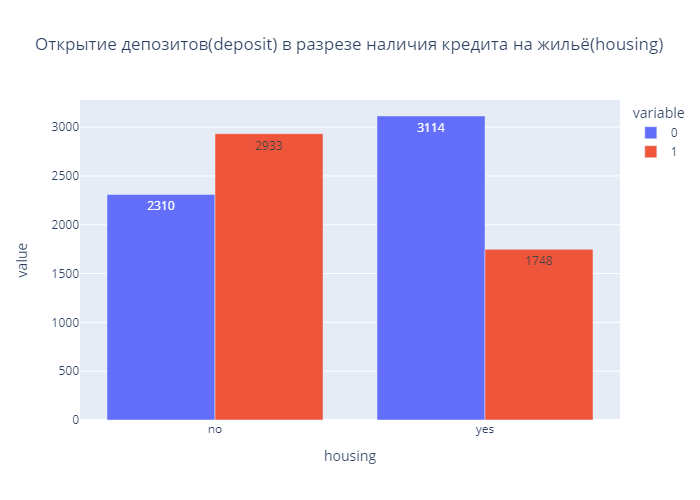

In [26]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='housing',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='housing', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе наличия кредита на жильё(housing)')
fig.show('png')

Видна явная тенденция, что клиенты не обременённые кредитом на жильём в большинстве случаев соглашаются на открытие депозитов, чем те, у которых имеется кредит, что говорит о наличии у них свободных средств.

**10. MONTH(месяц, в котором был последний контакт)**

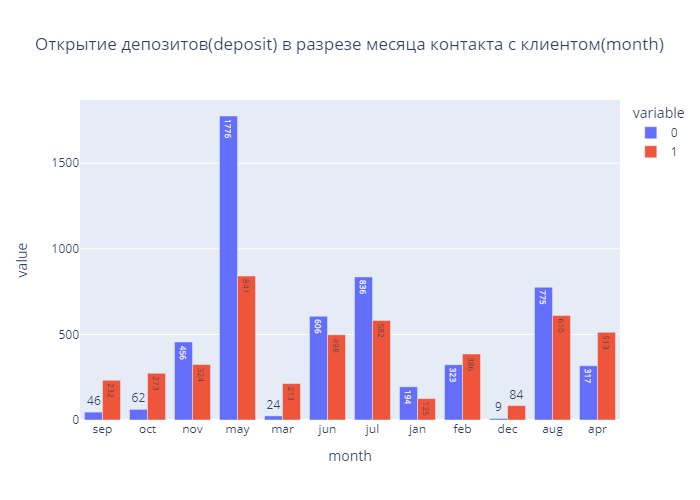

In [27]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='month',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='month', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе месяца контакта с клиентом(month)')
fig.show('png')

Больше всего контактов было совершено в мае месяце, положительная тенденция в открытии депозитов была отмечена в феврале, марте, апреле, сентябре, октябре, декабре. 

**11. POUTCOME(результат прошлой маркетинговой кампании)**

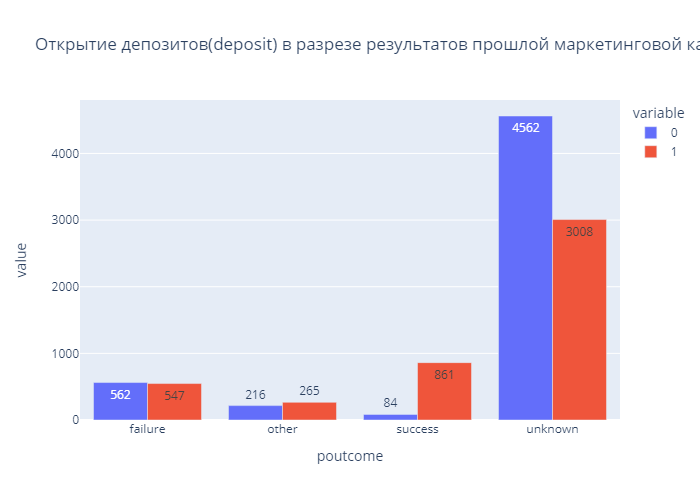

In [28]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='poutcome',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='poutcome', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе результатов прошлой маркетинговой кампании(poutcome)')
fig.show('png')

Клиенты, согласившиеся открыть депозит по результатам прошлой кампании(success) охотно открывают депозит и в результате новой кампании т.е. становятся лояльными. Из клиентов отказавшиеся от открытия депозита в прошлу кампанию - половина отказывается открывать депозит и в новую кампанию.

In [29]:
df_cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


### Задание 6

In [30]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_cleaned.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   0           562
          1           547
other     1           265
          0           216
success   1           861
          0            84
unknown   0          4562
          1          3008
Name: count, dtype: int64

Для клиентов группы poutcome(success) в предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 7

In [31]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month = df_cleaned.groupby('month')['deposit'].value_counts().unstack()
month

deposit,0,1
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


In [32]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
no_deposit = df_cleaned[(df_cleaned['deposit'] == 0)]
no_deposit.groupby('month')['deposit'].count().sort_values(ascending=False).nlargest(1)

month
may    1776
Name: deposit, dtype: int64

### Задание 8

In [33]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df_cleaned['age_group'] = df_cleaned['age'].apply(create_age_group)

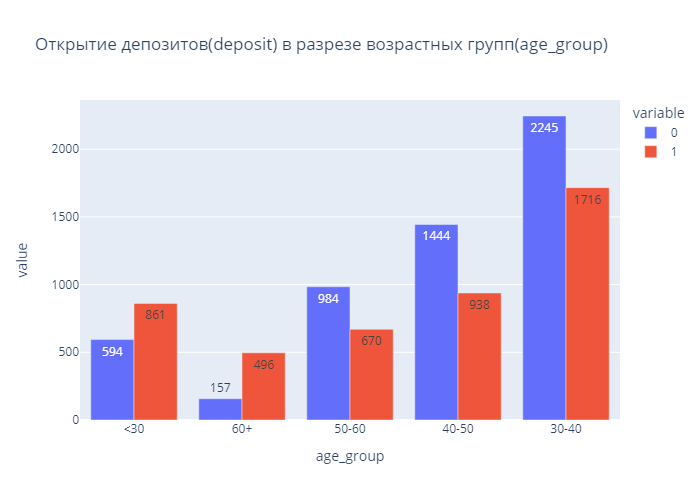

In [34]:
fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(age_group)')
fig.show('png')

Две возрастные группы, которые более склонны открывать депозит - <30 и 60+

### Задания 9 и 10

In [35]:
# сводная таблица, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
round(df_cleaned.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1]/df_cleaned.groupby(['education', 'marital'])['deposit'].count() * 100)

education  marital 
primary    divorced    51.0
           married     35.0
           single      45.0
secondary  divorced    43.0
           married     41.0
           single      50.0
tertiary   divorced    52.0
           married     49.0
           single      59.0
dtype: float64

Клиенты, которые чаще открывают депозит имеют уровень образования tertiary и семейный статус single или divorced, а также с образованием primary и семейным статусом divorced. 

Меньше всего -  с комбинацией primary/married.

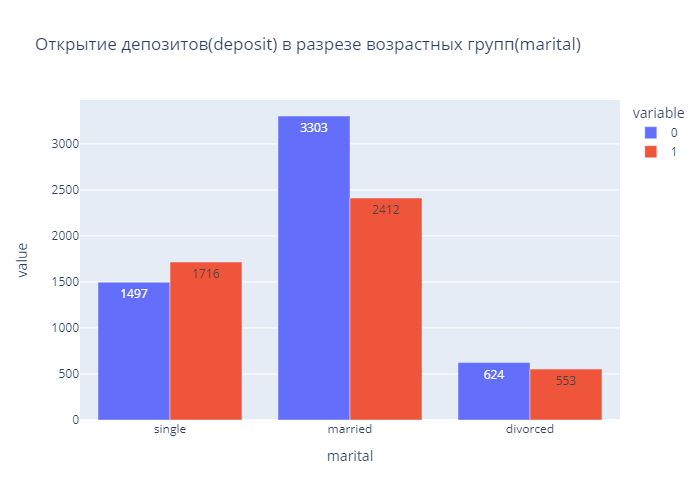

In [36]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='marital',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='marital', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(marital)')
fig.show('png')

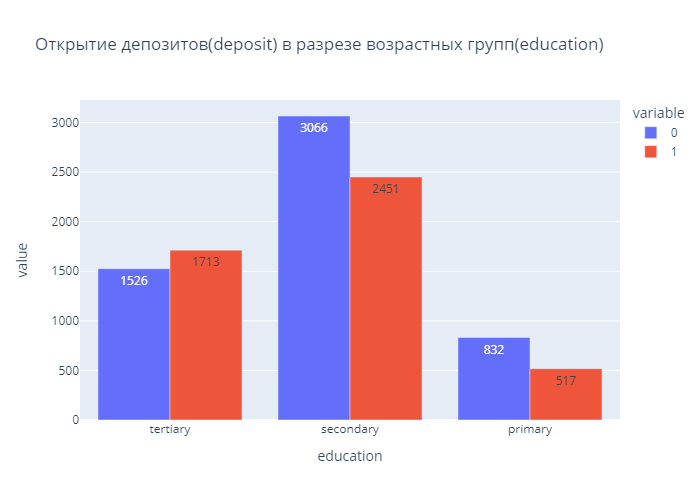

In [37]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='education', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(education)')
fig.show('png')

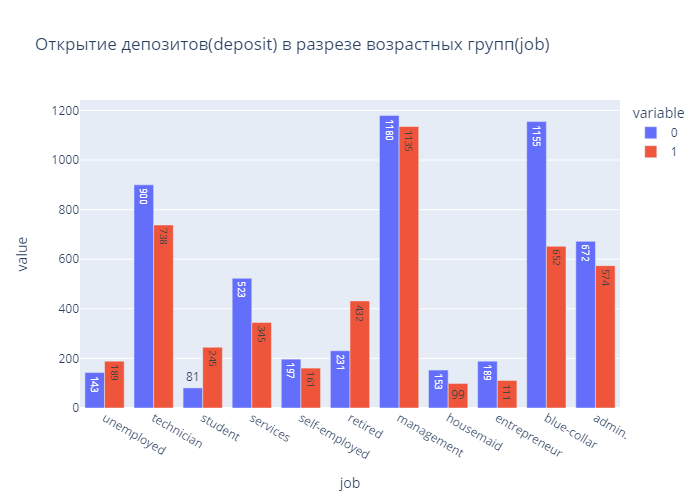

In [38]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig = px.bar(df_cleaned.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='job', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(job)')
fig.show('png')

In [39]:
df_cleaned['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

### Задание 11

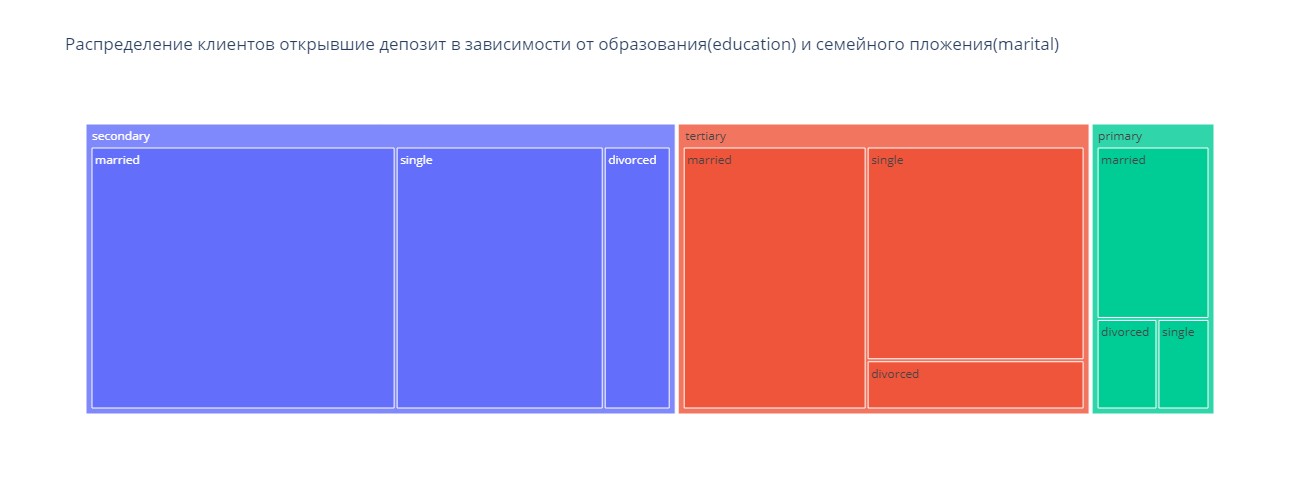

In [40]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

p1 = df_cleaned[df_cleaned['deposit']==1]
p1 = pd.DataFrame(p1.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p1, #DataFrame
    path=[p1.index.get_level_values(0), p1.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=1, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов открывшие депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')

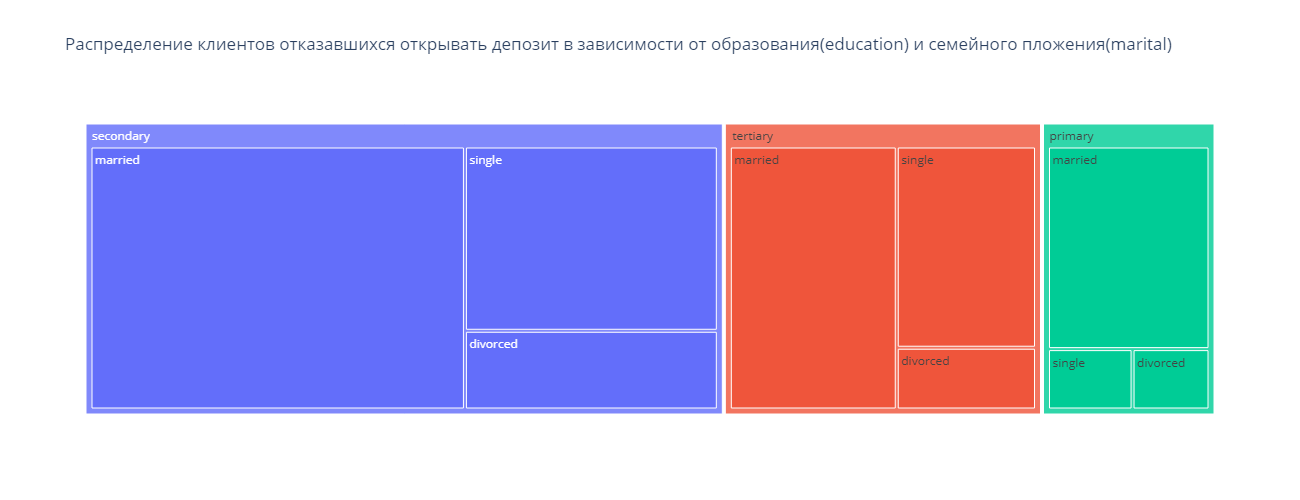

In [41]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто отказался открыть депозит)
p2 = df_cleaned[df_cleaned['deposit']==0]
p2 = pd.DataFrame(p2.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p2, #DataFrame
    path=[p2.index.get_level_values(0), p2.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=0, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов отказавшихся открывать депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')

## Часть 3: преобразование данных

### Задание 1

In [42]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df_cleaned['education'])
df_cleaned['education_cod'] = data_educ
display(df_cleaned['education_cod'].sum())

# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df_cleaned['age_group'])
df_cleaned['age_group'] = data_age

11995

### Задания 2 и 3

In [43]:
df_cleaned['deposit'].std().round(3)

0.499

In [44]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_cleaned['housing_bin'] = df_cleaned['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df_cleaned['default_bin'] = df_cleaned['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df_cleaned['loan_bin'] = df_cleaned['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

In [45]:
df_s = df_cleaned['housing_bin'].mean() + df_cleaned['default_bin'].mean() + df_cleaned['loan_bin'].mean()
display(df_s.round(3))

0.635

### Задание 4

In [46]:
# создайте дамми-переменные
df_cleaned = pd.get_dummies(df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'], prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df_drop = df_cleaned.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

In [47]:
df_cleaned.shape

(10105, 50)

In [48]:
df = df_drop

### Задания 5 и 6

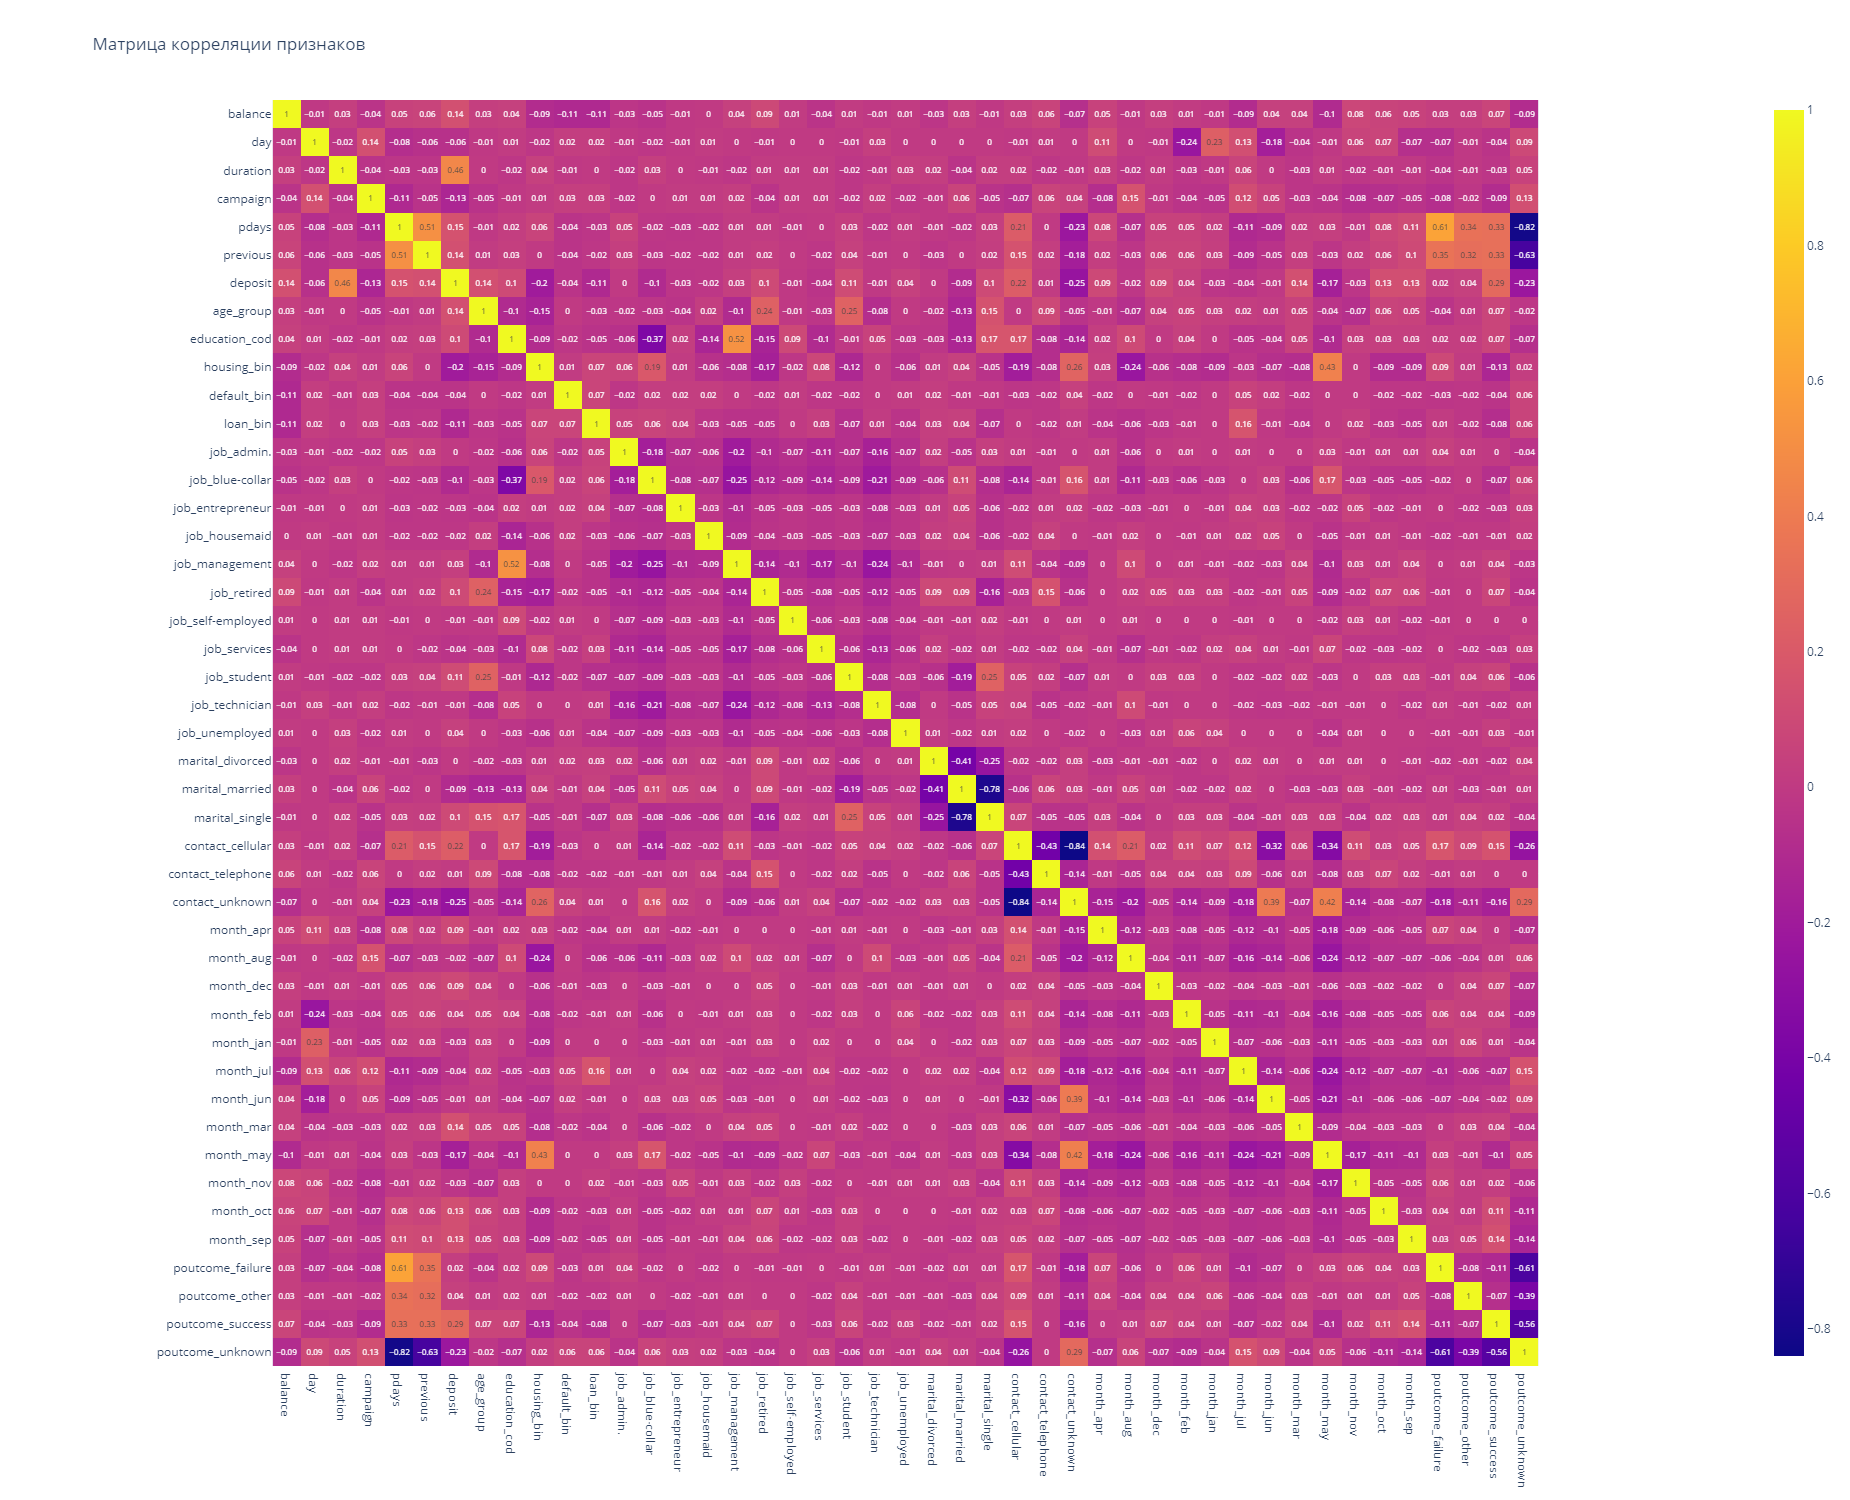

In [49]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show('png')

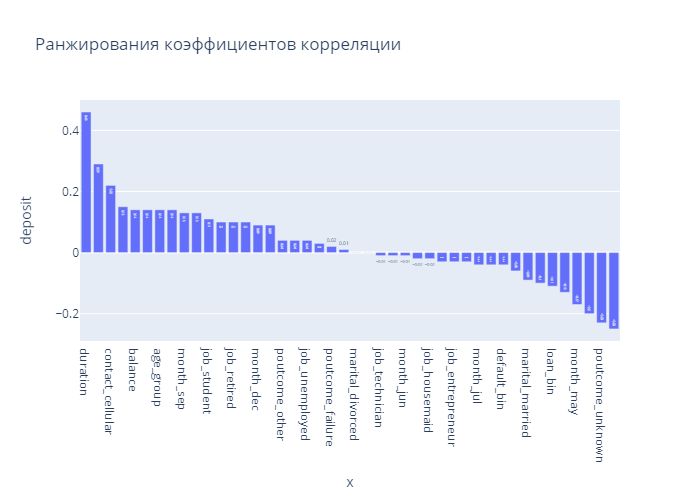

In [50]:
corrs = round(df.corr(), 2).drop('deposit', axis=0)

fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Ранжирования коэффициентов корреляции'
             )

fig.show('png')  

Мультиколлинеарность признаков отсутсвует. 

Признаки наиболее коррелирующие с целевой переменной:
- продолжительность контакта в секундах(duration)
- успех результата прошлой маркетинговой кампании(poutcome_success)
- контакт с клиентом по сотовому(contact_cellular)

### Задания 7 и 8

In [51]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [52]:
print(f'Размер train выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер test выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер train выборки X_train=(6770, 44), y_train=6770
Размер test выборки X_test=(3335, 44), y_test=3335


In [53]:
df['deposit'].mean().round(2)

0.46

### Задание 9

In [54]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'housing_bin',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [55]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [56]:
# Среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
X_test_scal[:, 0].mean().round(2)

0.47

In [57]:
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [58]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scal, y_train)
y_test_pred = log_model.predict(X_test_scal)
y_train_pred = log_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



### Задания 2,3,4

In [59]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



### Задание 5

In [60]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.795
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      3634
           1       0.85      0.77      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [66]:
# обучите на ваших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scal, y_train)
y_train_pred = forest_model.predict(X_train_scal)
y_test_pred = forest_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770



### Задания 2 и 3

In [67]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    learning_rate=0.05,
    max_depth=5         
)

gb.fit(X_train_scal, y_train)
y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      3634
           1       0.89      0.92      0.91      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770



### Задание 4

In [69]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_model),
    ('dt',  tree_model),
    ('fm', forest_model),
    ('gb', gb)      
]

#Создаем объект класса стекинг
steg_model = StackingClassifier(
    estimators=estimators,
    final_estimator=gb)
    

steg_model.fit(X_train_scal, y_train)
y_train_pred = steg_model.predict(X_train_scal)
y_test_pred = steg_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1790
           1       0.81      0.89      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.86      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      3634
           1       0.87      0.94      0.90      3136

    accuracy                           0.90      6770
   macro avg       0.90      0.91      0.90      6770
weighted avg       0.91      0.90      0.91      6770



### Задание 5

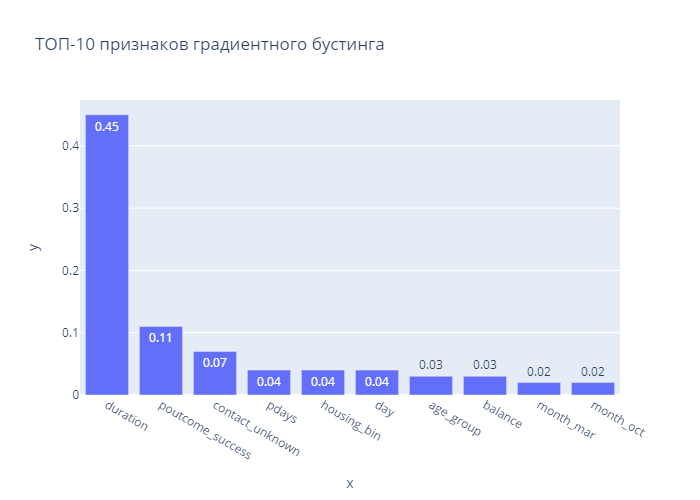

In [70]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
df_p = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(df_p.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(df_p.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

### Задания 6,7,8

In [72]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = forest_model
  
  # обучаем модель 
  model.fit(X_train_scal, y_train)
  y_train_pred = model.predict(X_train)
  score = metrics.f1_score(y_train, y_train_pred)

  return score

In [73]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scal, y_train)
y_test_pred = model.predict(X_test_scal)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2025-01-15 00:48:29,196] A new study created in memory with name: RandomForestClassifier
[I 2025-01-15 00:48:29,893] Trial 0 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 146, 'max_depth': 24, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.6331516252776095.
[I 2025-01-15 00:48:30,530] Trial 1 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 119, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6331516252776095.
[I 2025-01-15 00:48:31,156] Trial 2 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 132, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6331516252776095.
[I 2025-01-15 00:48:31,814] Trial 3 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 176, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6331516252776095.
[I 2025-01-15 00:48:32,424] Trial 4 finished with value: 0.6331516252776095 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 146, 'max_depth': 24, 'min_samples_leaf': 9}
F1 for test data=0.84
Accuracy for test data=0.84


## Выводы

Итоговый свод по моделям, оценённым по метрикам F1 и Accuracy представлен в таблице ниже. 

Для решения задачи классификации в данном кейсе хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna. 

В ходе исследования выделили три наиболее важных признака(далее признаки перечислены по мере убывания важности):
- **duration (продолжительность контакта в секундах)** -  оптимальная продолжительность контакта находится в диапазоне - от 240 до 340 секунд.
- **poutcome_success(результат прошлой маркетинговой кампании - success(успех, согласие))**
- **contact_unknown(тип контакта с клиентом- unknown(неизвестный))**

Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д. 

Вторичны факторы внутренние для конкретного клиента:
- **job_student**, **job_retired**(сфера занятости) - целевая аудитория это студенты и клиенты находящиеся на пенсии
- **age_group**(возрастная группа) - потенциальные группы - младше 31 и старше 60
- **marital** (семейное положение) - клиенты не состоящие в браке
- **month**(месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

и т.д., которые тоже влияют на решение клиента в меньшей степени, но необходимо учитывать при планировании будущей маркетинговой кампании.

Также стоит упомянуть о лояльности клиентах - как показали исследования клиентов ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и poutcome(результат прошлой маркетинговой кампании).

|      **МЕТОД/МЕТРИКИ**         |  **F1** |  **ACCURACY** |
|:-------------------|:------------------|:------------------|
|LogisticRegression|    0.80      |      0.82      |
|DecisionTreeClassifier|       0.80       |   0.81     | 
|RandomForestClassifier  |    0.83       |       0.84       | 
|GradientBoostingClassifier |       **0.85**       |       **0.85**     | 
|StackingClassifier |       **0.85**      |       **0.85**    | 
|RandomForestClassifier whith Optuna |       **0.84**       |       **0.84**    | 